# GAStimator tutorial


GAStimator is an umplementation of a Python MCMC gibbs-sampler with adaptive stepping. It is simple and robust, and very useful for high dimensional problems with many degrees of freedom and very sharp likelihood features. It has been developed and used for kinematic modelling of molecular gas in galaxies, but is fully general and may be used for any problem MCMC methods can tackle.

### Install
You can install GAStimator with `pip install gastimator`
    
It requires the following modules:

* numpy
* matplotlib
* progress

Once its installed we can get cracking!

### Basic Example - straight line fitting

One of the most simple things you may wish to do with a minimiser is fit a straight line to some data - so lets try that! 

Note: fitting a straight line well is actually _really_ hard ( see e.g. https://arxiv.org/abs/1008.4686 ) this tutorial does this in a very naive way, to demonstrate how GAStimator works!

First lets generate some straight line data, and add some noise:

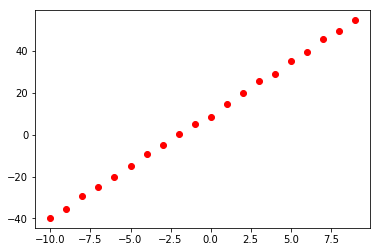

In [16]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


truth=np.array([10,5])
x=np.arange(-10.,10.)
error=0.5

data=truth[0]+(truth[1]*x)
data+=np.random.normal(size=x.size)*error
plt.plot(x,data,'ro')
plt.show()


Now we have some mock data, we need to make a model function that can be used to fit it. This function MUST take a numpy array of guesses as its first argument, but can also take any number of other arguments and keywords. 

In [17]:
def model(guesses,x):
    return guesses[0]+(x*guesses[1])

Now we can start the fitting process. By importing GAStimator, and pointing it to the model. Any arguments can be passed as args, and any keyword arguments with kwargs. 

In [18]:
from gastimator import gastimator

mcmc = gastimator(model,x)

Next we have to specify the details of the parameters we wish to use in the fit. By default GAStimator assumes flat (non-informative) priors- see later sections for how to change this.

In [19]:
mcmc.labels=np.array(['Intercept','Gradient'])
mcmc.guesses=np.array([2,19]) # these are purposefully way off
mcmc.min=np.array([0.,0.]) # allow the fit to guess values between zero...
mcmc.max=np.array([20.,20.]) # ... and 20 in each parameter
mcmc.fixed=np.array([False, False]) #if you would like to fix a variable then you can set its value to True here.

The one parameter which may need more explanation is the precision- basicly here you just want to take a guess about how well you will be able to constrain each parameter. The value you choose shouldnt be crucial for the fit, but it helps speed it up if you guess correctly...

In [20]:
mcmc.precision=np.array([1.,1.]) #here we assume we can get the intercept and gradient within ±1.0 - very conservative 

Now we are ready to go. To run the MCMC, simply pass it the data and the 1sigma errors, along with a number of samples to do, and let it get to work!

Note, if you set plot=True you can watch the chains as the progress. This is great when you are working with a new problem, but does slow things down a lot!

In [21]:
nsamples=30000
outputvalue, outputll= mcmc.run(data,error,nsamples,plot=False)

Doing chain 1
     Chain has not converged - Accept rate: 0.13
     Chain has not converged - Accept rate: 0.17
     Still varying: ['Intercept' 'Gradient']
Chain converged: LL: -9.202928581040666 - Accept rate:0.34
Best chain so far!
Best fit:
  Intercept: 9.967637634755688
  Gradient: 4.979998646076284
Starting final chain
Final best fit values and 1sigma errors:
  Intercept: 9.981016987290074 ± 0.11796798010503551
  Gradient: 4.983071218013056 ± 0.02056535418185579


As you can see Gastimator prints a decent amount of information as it goes. If you dont want this, feel free to set `mcmc.silent=True`

Once the MCMC is run, you likely want to visualise your results! I have included a version of cornor.cornor ( https://corner.readthedocs.io ), which has been modified by Michele Cappellari ( https://www-astro.physics.ox.ac.uk/~mxc/software/ ) and then further by myself. To use it to make a nice plot you just need to do:

Quantiles:
[(0.16, 9.857873361354917), (0.5, 9.981016987290074), (0.84, 10.092890031138351)]
Quantiles:
[(0.16, 4.961645290378986), (0.5, 4.983071218013056), (0.84, 5.002432762182683)]


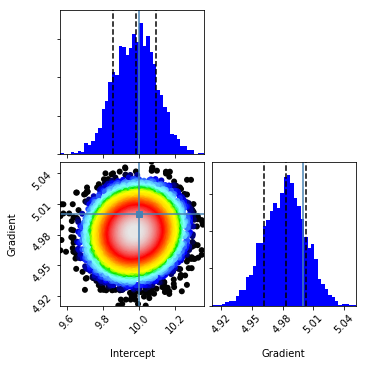

In [22]:
from gastimator import corner_plot

figure = corner_plot.corner_plot(outputvalue.T,like=outputll,labels=mcmc.labels,quantiles=[0.16, 0.5, 0.84], truths=truth)

### Including priors

If you would like to include priors in your fit, GAStimator makes it easy! Currently the priors class in GAStimator includes support for gaussian priors, but its easy to add your own too.

In [23]:
from gastimator import priors

interceptprior=priors.gaussian(10,1.0) # set a gaussian prior with a centre of 10, and an sigma of 1.0 for the intercept
gradprior=priors.gaussian(4.5,2) # set a gaussian prior with a centre of 4.5, and an sigma of 2 for the gradient
mcmc.prior_func=(interceptprior.eval, gradprior.eval)

If you would like to define your own prior go ahead! All you need is to create a function which takes a single number, and outputs the probability of that guess. For instance the intercept prior above could be coded as:

In [24]:
def myown_interceptprior(x):
    mu=10.
    sigma=1.0
    x = (x - mu) / sigma
    return np.exp(-x*x/2.0) / np.sqrt(2.0*np.pi) / sigma

Which could then be included in the fit by setting:

In [25]:
mcmc.prior_func=(myown_interceptprior, gradprior.eval)

Lets give that a try!

Doing chain 1
     Chain has not converged - Accept rate: 0.16
     Chain has not converged - Accept rate: 0.21
     Still varying: ['Intercept' 'Gradient']
Chain converged: LL: -11.889527601572484 - Accept rate:0.31
Best chain so far!
Best fit:
  Intercept: 10.0109356930565
  Gradient: 4.9751272062976275
Starting final chain
Final best fit values and 1sigma errors:
  Intercept: 9.973771616956272 ± 0.11939676607729233
  Gradient: 4.983685471771715 ± 0.020444939670343665
Quantiles:
[(0.16, 9.856114472319728), (0.5, 9.973771616956272), (0.84, 10.093695280689808)]
Quantiles:
[(0.16, 4.962969503597701), (0.5, 4.983685471771715), (0.84, 5.003534627628948)]


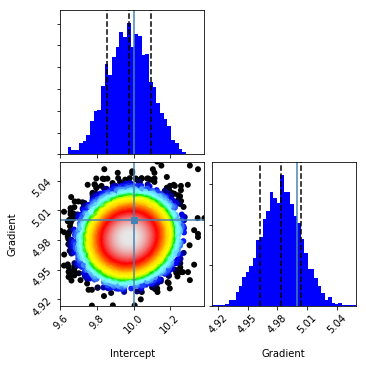

In [26]:
outputvalue, outputll= mcmc.run(data,error,nsamples,plot=False)
figure = corner_plot.corner_plot(outputvalue.T,like=outputll,labels=mcmc.labels,quantiles=[0.16, 0.5, 0.84], truths=truth)